# GPU
:label:`sec_use_gpu`

在 :numref:`tab_intro_decade`中，
我们回顾了过去20年计算能力的快速增长。
简而言之，自2000年以来，GPU性能每十年增长1000倍。

本节，我们将讨论如何利用这种计算性能进行研究。
首先是如何使用单个GPU，然后是如何使用多个GPU和多个服务器（具有多个GPU）。

我们先看看如何使用单个NVIDIA GPU进行计算。
首先，确保至少安装了一个NVIDIA GPU。
然后，下载[NVIDIA驱动和CUDA](https://developer.nvidia.com/cuda-downloads)
并按照提示设置适当的路径。
当这些准备工作完成，就可以使用`nvidia-smi`命令来(**查看显卡信息。**)


In [115]:
!nvidia-smi

Mon Nov 20 14:38:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.03    Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro K620         On   | 00000000:01:00.0 Off |                  N/A |
| 40%   51C    P8     1W /  30W |   1991MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

在PyTorch中，每个数组都有一个设备（device），
我们通常将其称为环境（context）。
默认情况下，所有变量和相关的计算都分配给CPU。
有时环境可能是GPU。
当我们跨多个服务器部署作业时，事情会变得更加棘手。
通过智能地将数组分配给环境，
我们可以最大限度地减少在设备之间传输数据的时间。
例如，当在带有GPU的服务器上训练神经网络时，
我们通常希望模型的参数在GPU上。


要运行此部分中的程序，至少需要两个GPU。
注意，对大多数桌面计算机来说，这可能是奢侈的，但在云中很容易获得。
例如可以使用AWS EC2的多GPU实例。
本书的其他章节大都不需要多个GPU，
而本节只是为了展示数据如何在不同的设备之间传递。

## [**计算设备**]

我们可以指定用于存储和计算的设备，如CPU和GPU。
默认情况下，张量是在内存中创建的，然后使用CPU计算它。


在PyTorch中，CPU和GPU可以用`torch.device('cpu')`
和`torch.device('cuda')`表示。
应该注意的是，`cpu`设备意味着所有物理CPU和内存，
这意味着PyTorch的计算将尝试使用所有CPU核心。
然而，`gpu`设备只代表一个卡和相应的显存。
如果有多个GPU，我们使用`torch.device(f'cuda:{i}')`
来表示第$i$块GPU（$i$从0开始）。
另外，`cuda:0`和`cuda`是等价的。


In [116]:
import torch
from torch import nn

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

我们可以(**查询可用gpu的数量。**)


In [117]:
torch.cuda.device_count()

1

现在我们定义了两个方便的函数，
[**这两个函数允许我们在不存在所需所有GPU的情况下运行代码。**]


In [118]:
def try_gpu(i  =0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

## 张量与GPU

我们可以[**查询张量所在的设备。**]
默认情况下，张量是在CPU上创建的。


In [119]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

需要注意的是，无论何时我们要对多个项进行操作，
它们都必须在同一个设备上。
例如，如果我们对两个张量求和，
我们需要确保两个张量都位于同一个设备上，
否则框架将不知道在哪里存储结果，甚至不知道在哪里执行计算。

### [**存储在GPU上**]

有几种方法可以在GPU上存储张量。
例如，我们可以在创建张量时指定存储设备。接
下来，我们在第一个`gpu`上创建张量变量`X`。
在GPU上创建的张量只消耗这个GPU的显存。
我们可以使用`nvidia-smi`命令查看显存使用情况。
一般来说，我们需要确保不创建超过GPU显存限制的数据。


In [130]:
torch.cuda.empty_cache()
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

假设我们至少有两个GPU，下面的代码将在(**第二个GPU上创建一个随机张量。**)


In [121]:
Y = torch.rand(2, 3, device=try_gpu(0))
Y

tensor([[0.1557, 0.5832, 0.9773],
        [0.0194, 0.7136, 0.1219]], device='cuda:0')

### 复制

如果我们[**要计算`X + Y`，我们需要决定在哪里执行这个操作**]。
例如，如 :numref:`fig_copyto`所示，
我们可以将`X`传输到第二个GPU并在那里执行操作。
*不要*简单地`X`加上`Y`，因为这会导致异常，
运行时引擎不知道该怎么做：它在同一设备上找不到数据会导致失败。
由于`Y`位于第二个GPU上，所以我们需要将`X`移到那里，
然后才能执行相加运算。

![复制数据以在同一设备上执行操作](../img/copyto.svg)
:label:`fig_copyto`


In [122]:
Z = X.cuda(0)
print(X)
print(Z)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')


[**现在数据在同一个GPU上（`Z`和`Y`都在），我们可以将它们相加。**]


In [123]:
Y + Z

tensor([[1.1557, 1.5832, 1.9773],
        [1.0194, 1.7136, 1.1219]], device='cuda:0')

假设变量`Z`已经存在于第二个GPU上。
如果我们还是调用`Z.cuda(1)`会发生什么？
它将返回`Z`，而不会复制并分配新内存。


In [125]:
Z.cuda(0) is Z

True

### 旁注

人们使用GPU来进行机器学习，因为单个GPU相对运行速度快。
但是在设备（CPU、GPU和其他机器）之间传输数据比计算慢得多。
这也使得并行化变得更加困难，因为我们必须等待数据被发送（或者接收），
然后才能继续进行更多的操作。
这就是为什么拷贝操作要格外小心。
根据经验，多个小操作比一个大操作糟糕得多。
此外，一次执行几个操作比代码中散布的许多单个操作要好得多。
如果一个设备必须等待另一个设备才能执行其他操作，
那么这样的操作可能会阻塞。
这有点像排队订购咖啡，而不像通过电话预先订购：
当客人到店的时候，咖啡已经准备好了。

最后，当我们打印张量或将张量转换为NumPy格式时，
如果数据不在内存中，框架会首先将其复制到内存中，
这会导致额外的传输开销。
更糟糕的是，它现在受制于全局解释器锁，使得一切都得等待Python完成。

## [**神经网络与GPU**]

类似地，神经网络模型可以指定设备。
下面的代码将模型参数放在GPU上。


In [127]:
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device=try_gpu())

在接下来的几章中，
我们将看到更多关于如何在GPU上运行模型的例子，
因为它们将变得更加计算密集。

当输入为GPU上的张量时，模型将在同一GPU上计算结果。


In [128]:
net(X)

tensor([[-0.3032],
        [-0.3032]], device='cuda:0', grad_fn=<AddmmBackward0>)

让我们(**确认模型参数存储在同一个GPU上。**)


In [129]:
net[0].weight.data.device

device(type='cuda', index=0)

总之，只要所有的数据和参数都在同一个设备上，
我们就可以有效地学习模型。
在下面的章节中，我们将看到几个这样的例子。

## 小结

* 我们可以指定用于存储和计算的设备，例如CPU或GPU。默认情况下，数据在主内存中创建，然后使用CPU进行计算。
* 深度学习框架要求计算的所有输入数据都在同一设备上，无论是CPU还是GPU。
* 不经意地移动数据可能会显著降低性能。一个典型的错误如下：计算GPU上每个小批量的损失，并在命令行中将其报告给用户（或将其记录在NumPy `ndarray`中）时，将触发全局解释器锁，从而使所有GPU阻塞。最好是为GPU内部的日志分配内存，并且只移动较大的日志。

## 练习

1. 尝试一个计算量更大的任务，比如大矩阵的乘法，看看CPU和GPU之间的速度差异。再试一个计算量很小的任务呢？
1. 我们应该如何在GPU上读写模型参数？
1. 测量计算1000个$100 \times 100$矩阵的矩阵乘法所需的时间，并记录输出矩阵的Frobenius范数，一次记录一个结果，而不是在GPU上保存日志并仅传输最终结果。
1. 测量同时在两个GPU上执行两个矩阵乘法与在一个GPU上按顺序执行两个矩阵乘法所需的时间。提示：应该看到近乎线性的缩放。


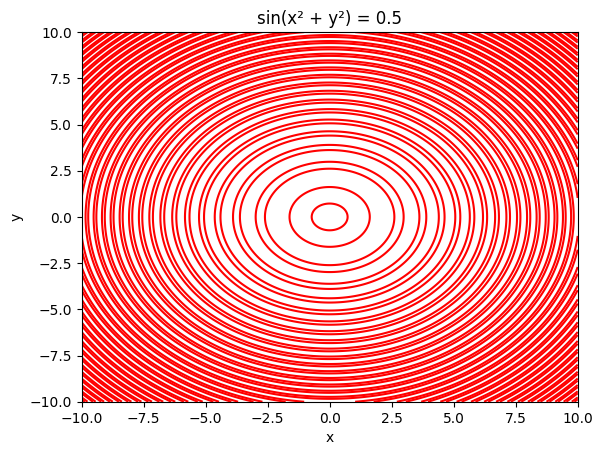

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数
def func(x, y):
    return np.sin(x**2 + y**2) - 0.5

# 生成 x 和 y 的值
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 10000)

# 创建网格
x, y = np.meshgrid(x, y)

# 计算函数的值
z = func(x, y)

# 绘制等值线图
plt.contour(x, y, z, levels=[0], colors='r')

# 添加标题和标签
plt.title('sin(x² + y²) = 0.5')
plt.xlabel('x')
plt.ylabel('y')

# 显示图形
plt.show()


[Discussions](https://discuss.d2l.ai/t/1841)
